# Project 4 Part I

## by Joseph Naro and Preeti Kumari

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, f1_score, confusion_matrix
from sklearn.utils import shuffle

# Part I: 1

### We have chosen the realTraffic speed_6005 dataset, because analyzing traffic data seemed interesting, and it was the largest dataset with traffic speed.

In [4]:
input_file = 'realTraffic/speed_6005.csv'

In [5]:
df = pd.read_csv(input_file)
df

,timestamp,value
0,2015-08-31 18:22:00,90
1,2015-08-31 18:32:00,80
2,2015-08-31 18:57:00,84
3,2015-08-31 19:07:00,94
4,2015-08-31 19:12:00,90
...,...,...
2495,2015-09-17 16:04:00,81
2496,2015-09-17 16:09:00,89
2497,2015-09-17 16:14:00,87
2498,2015-09-17 16:19:00,82


In [6]:
df.describe()

,value
count,2500.000000
mean,81.906800
std,8.746606
min,20.000000
25%,77.000000
50%,82.000000
75%,88.000000
max,109.000000


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df

,value
timestamp,
2015-08-31 18:22:00,90
2015-08-31 18:32:00,80
2015-08-31 18:57:00,84
2015-08-31 19:07:00,94
2015-08-31 19:12:00,90
...,...
2015-09-17 16:04:00,81
2015-09-17 16:09:00,89
2015-09-17 16:14:00,87


### Here we are getting the indexes of the relevant anomaly windows from the provided JSON file.

In [8]:
anomalies = json.load(open('combined_windows.json'))
anomalies

{'artificialNoAnomaly/art_daily_no_noise.csv': [],
 'artificialNoAnomaly/art_daily_perfect_square_wave.csv': [],
 'artificialNoAnomaly/art_daily_small_noise.csv': [],
 'artificialNoAnomaly/art_flatline.csv': [],
 'artificialNoAnomaly/art_noisy.csv': [],
 'artificialWithAnomaly/art_daily_flatmiddle.csv': [['2014-04-10 07:15:00.000000',
   '2014-04-11 16:45:00.000000']],
 'artificialWithAnomaly/art_daily_jumpsdown.csv': [['2014-04-10 16:15:00.000000',
   '2014-04-12 01:45:00.000000']],
 'artificialWithAnomaly/art_daily_jumpsup.csv': [['2014-04-10 16:15:00.000000',
   '2014-04-12 01:45:00.000000']],
 'artificialWithAnomaly/art_daily_nojump.csv': [['2014-04-10 16:15:00.000000',
   '2014-04-12 01:45:00.000000']],
 'artificialWithAnomaly/art_increase_spike_density.csv': [['2014-04-07 06:25:00.000000',
   '2014-04-08 15:55:00.000000']],
 'artificialWithAnomaly/art_load_balancer_spikes.csv': [['2014-04-10 11:50:00.000000',
   '2014-04-11 21:20:00.000000']],
 'realAWSCloudwatch/ec2_cpu_utilizat

In [9]:
relevant_anomalies = anomalies[input_file]
for index in range(len(relevant_anomalies)):
    relevant_anomalies[index] = pd.to_datetime(relevant_anomalies[index])
    
relevant_anomalies

[DatetimeIndex(['2015-09-16 18:40:00', '2015-09-17 16:24:00'], dtype='datetime64[ns]', freq=None)]

### Below we have all of the data being used plotted nicely. The plot shows traffic speeds. The lack of data itself is a type of anomaly, but it is not what we are looking for this time. I checked the dates given and it looks like the long gap without any data was a weekend and a Monday. It is reasonable to infer that the data collector had the weekend off.

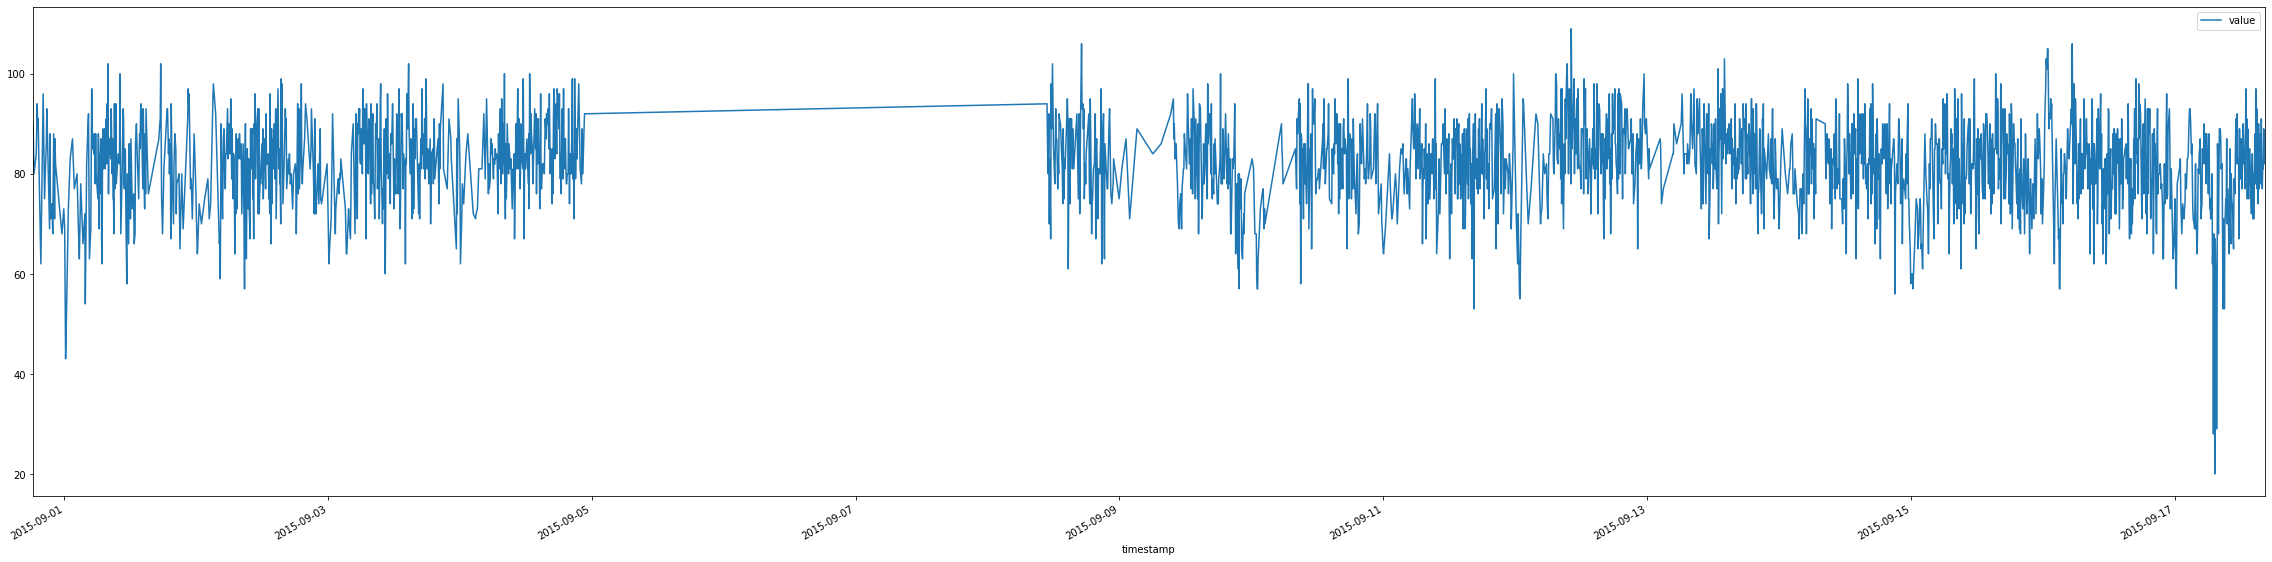

In [10]:
df.plot(figsize=(40,10))

In [11]:
anomaly_intervals = pd.DataFrame()

for interval in relevant_anomalies:
    anomaly_intervals = anomaly_intervals.append(df.loc[interval[0]:interval[1]])

anomaly_intervals

,value
timestamp,
2015-09-16 18:40:00,84
2015-09-16 18:45:00,72
2015-09-16 18:50:00,83
2015-09-16 18:55:00,68
2015-09-16 19:00:00,93
...,...
2015-09-17 16:04:00,81
2015-09-17 16:09:00,89
2015-09-17 16:14:00,87


### This plot has the anomaly colored in orange to highlight it. There is an obvious downward spike, likely the result of some sort of traffic jam. The rest of the anomaly is a bit harder to notice.

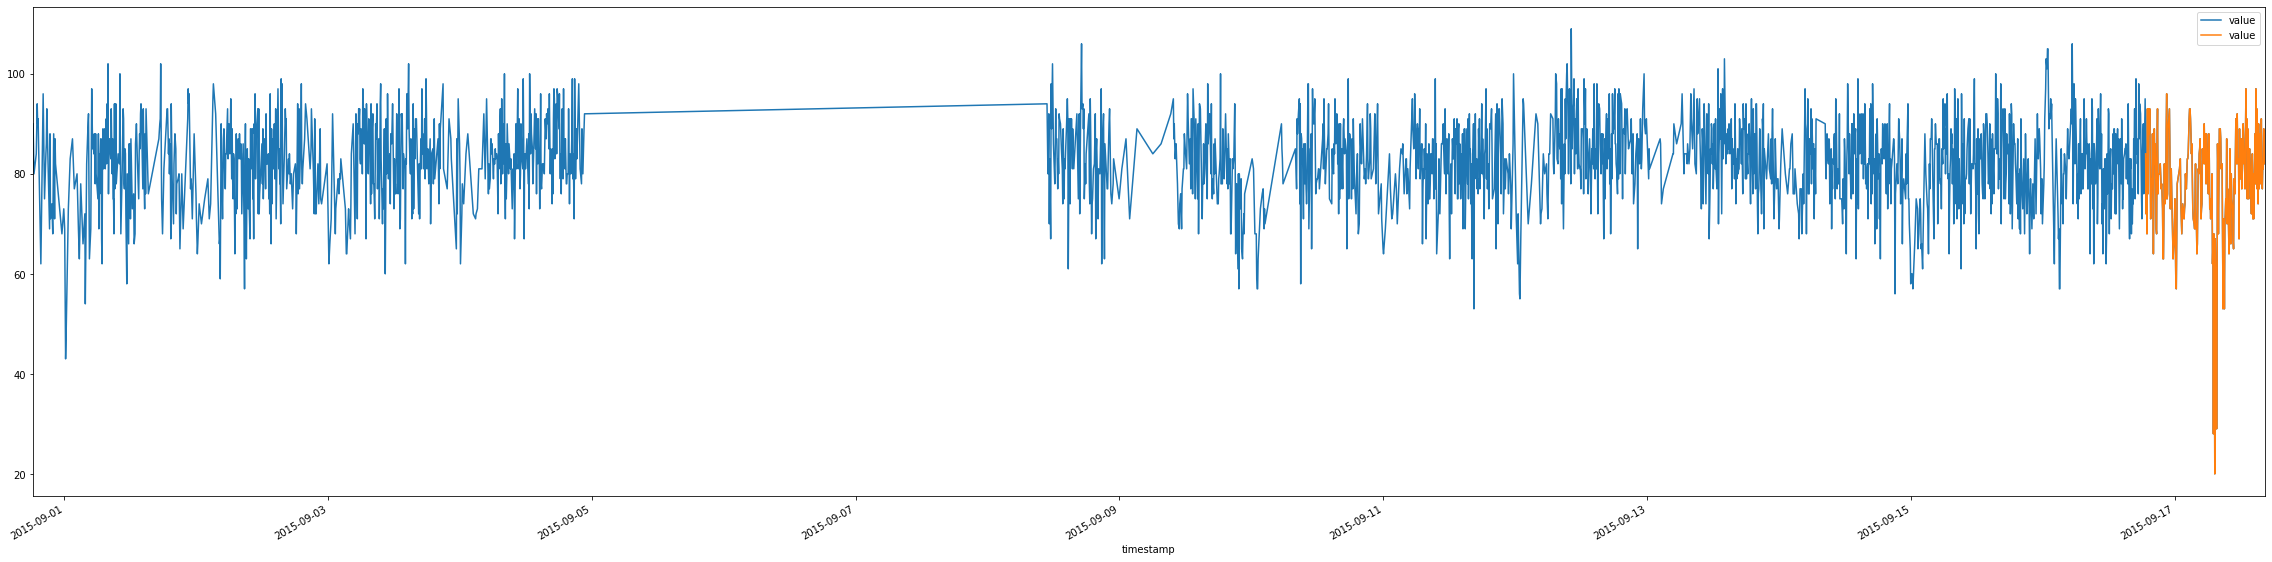

In [12]:
ax = df.plot(figsize=(40,10))
anomaly_intervals.plot(figsize=(40,10), ax=ax)

### Here's what the dataset looks like without the anomaly.

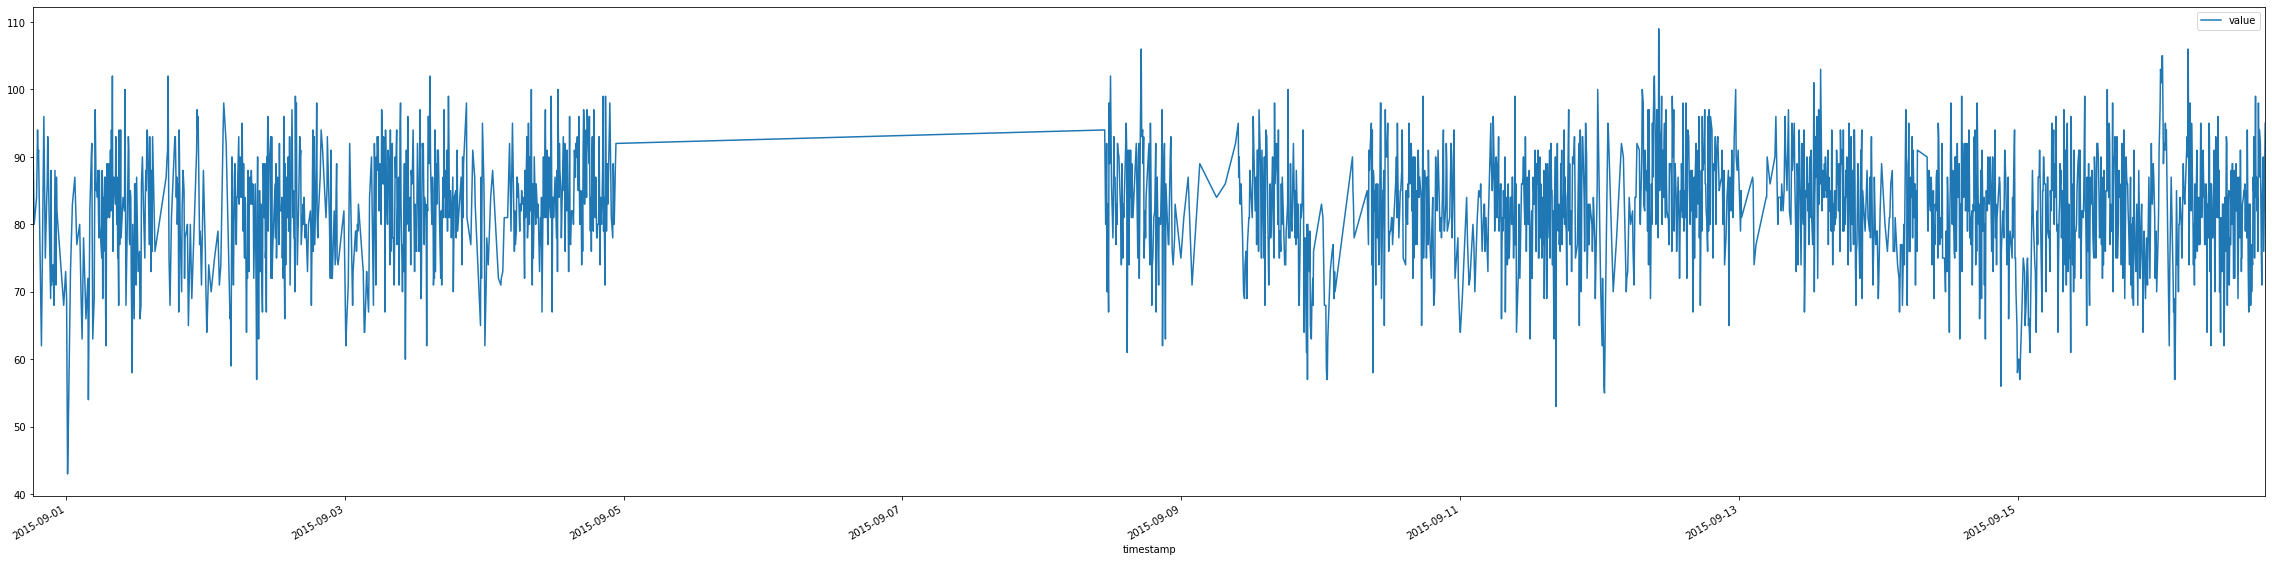

In [13]:
x = ((df.reset_index()).append(anomaly_intervals.reset_index()))
x.drop_duplicates(keep=False, inplace=True)
x.set_index('timestamp', inplace=True)
x.plot(figsize=(40,10))

In [14]:
def get_train_test_data(input_len, output_len, x):

    x = x.to_numpy()
    x_data = []
    y_data = []

    for i in range(len(x)-input_len+1-output_len):
        x_data.append(x[i:i+input_len])
        y_data.append(x[i+input_len:i+input_len+output_len])

    x_data = np.array(x_data).squeeze()
    y_data = np.array(y_data).squeeze()
    shuffle(x_data, y_data)

    x_train = x_data[:int(len(x_data)*.8)]
    x_test = x_data[int(len(x_data)*.8):]
    y_train = y_data[:int(len(y_data)*.8)]
    y_test = y_data[int(len(y_data)*.8):]
    
    return x_train, y_train, x_test, y_test

In [15]:
x_train, y_train, x_test, y_test = get_train_test_data(64, 5, x)

# Part I: 2, 3, & 4

### The different parts of this project are intertwined, so I cannot easily separate them into parts.

In [16]:
scores = []

In [17]:
stopper = EarlyStopping(monitor='val_loss', min_delta=1, patience=7, restore_best_weights=True)

In [18]:
model_1 = Sequential()
model_1.add(layers.Dense(64, activation='relu', input_shape=(64,)))
model_1.add(layers.Dense(32, activation='relu'))
model_1.add(layers.Dense(16, activation='relu'))
model_1.add(layers.Dense(8, activation='relu'))
model_1.add(layers.Dense(5, activation='relu'))
model_1.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'msle'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 45        
Total params: 6,949
Trainable params: 6,949
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_1_history = model_1.fit(x_train, y_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
model_1.save_weights('model_1.h5')

Epoch 1/40
22/22 [==============================] - 0s 19ms/step - loss: 6345.1299 - mse: 6345.1299 - mae: 78.5483 - msle: 16.2087 - val_loss: 5654.1646 - val_mse: 5654.1646 - val_mae: 70.9690 - val_msle: 15.6957
Epoch 2/40
22/22 [==============================] - 0s 4ms/step - loss: 5578.6338 - mse: 5578.6338 - mae: 68.7401 - msle: 15.6606 - val_loss: 5557.6650 - val_mse: 5557.6650 - val_mae: 68.0966 - val_msle: 15.6766
Epoch 3/40
22/22 [==============================] - 0s 4ms/step - loss: 5550.7842 - mse: 5550.7842 - mae: 67.8145 - msle: 15.6568 - val_loss: 5545.1797 - val_mse: 5545.1797 - val_mae: 67.4537 - val_msle: 15.6748
Epoch 4/40
22/22 [==============================] - 0s 4ms/step - loss: 5544.7852 - mse: 5544.7852 - mae: 67.5526 - msle: 15.6559 - val_loss: 5545.2251 - val_mse: 5545.2251 - val_mae: 67.4559 - val_msle: 15.6748
Epoch 5/40
22/22 [==============================] - 0s 3ms/step - loss: 5544.2466 - mse: 5544.2466 - mae: 67.5351 - msle: 15.6558 - val_loss: 5545.0288

In [20]:
model_1_score = model_1.evaluate(x_test, y_test, verbose=1)
scores.append(model_1_score[0])

14/14 [==============================] - 0s 1ms/step - loss: 5360.4136 - mse: 5360.4136 - mae: 66.4386 - msle: 15.5296


## This loss is pretty bad. I know from running the notebook multiple times that the network is actually stuck in a local minimum, and the model can frequently end training with a loss around 85. This is still not special enough to pursue.

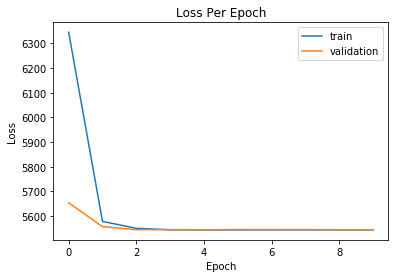

In [21]:
plt.plot(model_1_history.history['loss'])
plt.plot(model_1_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

In [22]:
model_2 = Sequential()
model_2.add(layers.Dense(64, input_shape=(64,)))
model_2.add(layers.LeakyReLU(alpha=0.1))
model_2.add(layers.Dense(32))
model_2.add(layers.LeakyReLU(alpha=0.1))
model_2.add(layers.Dense(16))
model_2.add(layers.LeakyReLU(alpha=0.1))
model_2.add(layers.Dense(8))
model_2.add(layers.LeakyReLU(alpha=0.1))
model_2.add(layers.Dense(5))
model_2.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'msle'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

In [23]:
model_2_history = model_2.fit(x_train, y_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
model_2.save_weights('model_2.h5')

Epoch 1/40
22/22 [==============================] - 0s 16ms/step - loss: 7610.9678 - mse: 7610.9678 - mae: 82.8469 - msle: 10.9654 - val_loss: 4258.1719 - val_mse: 4258.1719 - val_mae: 61.0812 - val_msle: 6.1761
Epoch 2/40
22/22 [==============================] - 0s 4ms/step - loss: 2982.5134 - mse: 2982.5134 - mae: 45.9210 - msle: 3.9831 - val_loss: 1692.8688 - val_mse: 1692.8688 - val_mae: 33.9660 - val_msle: 0.6958
Epoch 3/40
22/22 [==============================] - 0s 3ms/step - loss: 845.6870 - mse: 845.6870 - mae: 23.3162 - msle: 0.2508 - val_loss: 141.1813 - val_mse: 141.1813 - val_mae: 9.9648 - val_msle: 0.0212
Epoch 4/40
22/22 [==============================] - 0s 4ms/step - loss: 104.0607 - mse: 104.0607 - mae: 8.1348 - msle: 0.0155 - val_loss: 76.7740 - val_mse: 76.7740 - val_mae: 6.9151 - val_msle: 0.0112
Epoch 5/40
22/22 [==============================] - 0s 3ms/step - loss: 79.6329 - mse: 79.6329 - mae: 7.0898 - msle: 0.0120 - val_loss: 54.8747 - val_mse: 54.8747 - val_ma

In [24]:
model_2_score = model_2.evaluate(x_test, y_test, verbose=1)
scores.append(model_2_score[0])

14/14 [==============================] - 0s 1ms/step - loss: 81.1897 - mse: 81.1897 - mae: 7.2786 - msle: 0.0126


## As we can see, switching from Leaky ReLU helped immensely, and the network was able to avoid the local minimum that caught the first model.

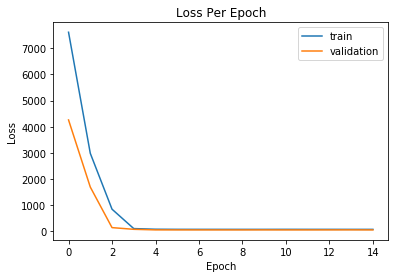

In [25]:
plt.plot(model_2_history.history['loss'])
plt.plot(model_2_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

In [26]:
x_train, y_train, x_test, y_test = get_train_test_data(128, 10, x)

In [27]:
model_3 = Sequential()
model_3.add(layers.Dense(64, input_shape=(128,)))
model_3.add(layers.LeakyReLU(alpha=0.1))
model_3.add(layers.Dense(32))
model_3.add(layers.LeakyReLU(alpha=0.1))
model_3.add(layers.Dense(16))
model_3.add(layers.LeakyReLU(alpha=0.1))
model_3.add(layers.Dense(10))
model_3.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'msle'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [28]:
model_3_history = model_3.fit(x_train, y_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
model_3.save_weights('model_3.h5')

Epoch 1/40
22/22 [==============================] - 0s 20ms/step - loss: 5274.0459 - mse: 5274.0459 - mae: 64.1983 - msle: 7.4469 - val_loss: 3252.8176 - val_mse: 3252.8176 - val_mae: 47.5718 - val_msle: 3.4598
Epoch 2/40
22/22 [==============================] - 0s 6ms/step - loss: 2049.1113 - mse: 2049.1113 - mae: 35.8296 - msle: 2.2458 - val_loss: 840.3271 - val_mse: 840.3271 - val_mae: 23.5922 - val_msle: 0.1967
Epoch 3/40
22/22 [==============================] - 0s 4ms/step - loss: 515.6143 - mse: 515.6143 - mae: 17.8849 - msle: 0.0891 - val_loss: 219.7996 - val_mse: 219.7996 - val_mae: 11.6378 - val_msle: 0.0317
Epoch 4/40
22/22 [==============================] - 0s 4ms/step - loss: 148.3751 - mse: 148.3751 - mae: 9.6708 - msle: 0.0219 - val_loss: 86.6433 - val_mse: 86.6433 - val_mae: 7.3227 - val_msle: 0.0132
Epoch 5/40
22/22 [==============================] - 0s 4ms/step - loss: 79.4536 - mse: 79.4536 - mae: 7.1119 - msle: 0.0119 - val_loss: 65.2394 - val_mse: 65.2394 - val_mae:

In [29]:
model_3_score = model_3.evaluate(x_test, y_test, verbose=1)
scores.append(model_3_score[0])

14/14 [==============================] - 0s 2ms/step - loss: 77.4033 - mse: 77.4033 - mae: 7.0551 - msle: 0.0117


## Using an input size twice as large did not help much, but asking it to forecast twice as many values may be part of the reason that the increased inputs did not significantly improve loss.

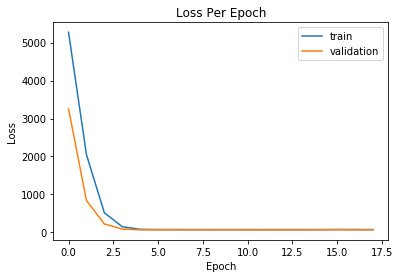

In [30]:
plt.plot(model_3_history.history['loss'])
plt.plot(model_3_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

In [31]:
x_train, y_train, x_test, y_test = get_train_test_data(128, 5, x)

In [32]:
model_4 = Sequential()
model_4.add(layers.Dense(64, input_shape=(128,)))
model_4.add(layers.LeakyReLU(alpha=0.1))
model_4.add(layers.Dense(32))
model_4.add(layers.LeakyReLU(alpha=0.1))
model_4.add(layers.Dense(16))
model_4.add(layers.LeakyReLU(alpha=0.1))
model_4.add(layers.Dense(8))
model_4.add(layers.LeakyReLU(alpha=0.1))
model_4.add(layers.Dense(5))
model_4.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'msle'])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                

In [33]:
model_4_history = model_4.fit(x_train, y_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
model_4.save_weights('model_4.h5')

Epoch 1/40
22/22 [==============================] - 0s 16ms/step - loss: 3701.5020 - mse: 3701.5020 - mae: 51.3464 - msle: 4.4114 - val_loss: 546.1859 - val_mse: 546.1859 - val_mae: 19.4582 - val_msle: 0.1027
Epoch 2/40
22/22 [==============================] - 0s 4ms/step - loss: 422.5430 - mse: 422.5430 - mae: 16.2332 - msle: 0.0601 - val_loss: 164.6893 - val_mse: 164.6893 - val_mae: 10.4775 - val_msle: 0.0250
Epoch 3/40
22/22 [==============================] - 0s 4ms/step - loss: 114.5825 - mse: 114.5825 - mae: 8.5604 - msle: 0.0173 - val_loss: 71.7620 - val_mse: 71.7620 - val_mae: 6.6159 - val_msle: 0.0112
Epoch 4/40
22/22 [==============================] - 0s 4ms/step - loss: 82.5403 - mse: 82.5403 - mae: 7.2283 - msle: 0.0123 - val_loss: 71.2051 - val_mse: 71.2051 - val_mae: 6.5410 - val_msle: 0.0111
Epoch 5/40
22/22 [==============================] - 0s 3ms/step - loss: 79.4394 - mse: 79.4394 - mae: 7.0911 - msle: 0.0119 - val_loss: 69.8580 - val_mse: 69.8580 - val_mae: 6.4789 - 

In [34]:
model_4_score = model_4.evaluate(x_test, y_test, verbose=1)
scores.append(model_4_score[0])

14/14 [==============================] - 0s 1ms/step - loss: 82.7850 - mse: 82.7850 - mae: 7.3160 - msle: 0.0125


## This time we've kept the the 128 inputs but went back to 5 outputs. It resulted in a small improvement, but the improvements are getting there. It's interesting to note that the loss graphs seems to all be reaching minimal loss after only one or two epochs.

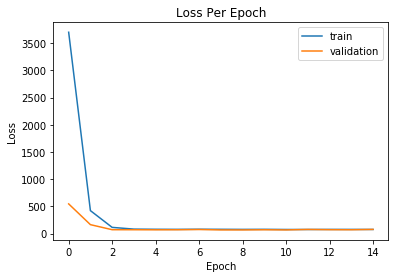

In [35]:
plt.plot(model_4_history.history['loss'])
plt.plot(model_4_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

In [36]:
model_5 = Sequential()
model_5.add(layers.Dense(64, input_shape=(128,)))
model_5.add(layers.LeakyReLU(alpha=0.1))
model_5.add(layers.Dense(32))
model_5.add(layers.LeakyReLU(alpha=0.1))
model_5.add(layers.Dense(16))
model_5.add(layers.LeakyReLU(alpha=0.1))
model_5.add(layers.Dense(5))
model_5.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'msle'])
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                528       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)                

In [37]:
model_5_history = model_5.fit(x_train, y_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
model_5.save_weights('model_5.h5')

Epoch 1/40
22/22 [==============================] - 0s 22ms/step - loss: 2094.9478 - mse: 2094.9478 - mae: 31.6072 - msle: 2.4701 - val_loss: 191.3457 - val_mse: 191.3457 - val_mae: 11.5677 - val_msle: 0.0276
Epoch 2/40
22/22 [==============================] - 0s 4ms/step - loss: 122.0609 - mse: 122.0609 - mae: 8.7718 - msle: 0.0184 - val_loss: 72.1887 - val_mse: 72.1887 - val_mae: 6.7321 - val_msle: 0.0112
Epoch 3/40
22/22 [==============================] - ETA: 0s - loss: 95.7811 - mse: 95.7811 - mae: 7.9156 - msle: 0.01 - 0s 4ms/step - loss: 88.0857 - mse: 88.0857 - mae: 7.4740 - msle: 0.0132 - val_loss: 70.4848 - val_mse: 70.4848 - val_mae: 6.5566 - val_msle: 0.0110
Epoch 4/40
22/22 [==============================] - 0s 3ms/step - loss: 84.5037 - mse: 84.5037 - mae: 7.3061 - msle: 0.0127 - val_loss: 69.4934 - val_mse: 69.4934 - val_mae: 6.5005 - val_msle: 0.0108
Epoch 5/40
22/22 [==============================] - 0s 4ms/step - loss: 83.5322 - mse: 83.5322 - mae: 7.2654 - msle: 0.01

In [38]:
model_5_score = model_5.evaluate(x_test, y_test, verbose=1)
scores.append(model_5_score[0])

14/14 [==============================] - 0s 2ms/step - loss: 82.6793 - mse: 82.6793 - mae: 7.2830 - msle: 0.0124


## Again, there's nothing really special to report here.

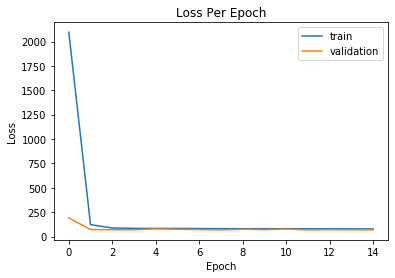

In [39]:
plt.plot(model_5_history.history['loss'])
plt.plot(model_5_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

Text(0, 0.5, 'Loss (MSE)')

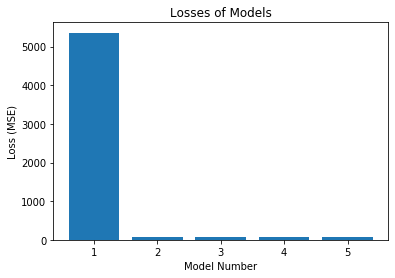

In [40]:
plt.bar(range(1,len(scores)+1), scores)
plt.xticks(range(1,len(scores)+1))
plt.title('Losses of Models')
plt.xlabel('Model Number')
plt.ylabel('Loss (MSE)')

## As you can see all of the models have pretty similar losses, excluding the first model, so we'll just go with Model 4 for the rest of our anomaly detection.

In [41]:
df

,value
timestamp,
2015-08-31 18:22:00,90
2015-08-31 18:32:00,80
2015-08-31 18:57:00,84
2015-08-31 19:07:00,94
2015-08-31 19:12:00,90
...,...
2015-09-17 16:04:00,81
2015-09-17 16:09:00,89
2015-09-17 16:14:00,87


In [42]:
df['true_anomaly'] = False
df['mse_anomaly'] = False
df['max_anomaly'] = False
df['mae_anomaly'] = False
df

,value,true_anomaly,mse_anomaly,max_anomaly,mae_anomaly
timestamp,,,,,
2015-08-31 18:22:00,90,False,False,False,False
2015-08-31 18:32:00,80,False,False,False,False
2015-08-31 18:57:00,84,False,False,False,False
2015-08-31 19:07:00,94,False,False,False,False
2015-08-31 19:12:00,90,False,False,False,False
...,...,...,...,...,...
2015-09-17 16:04:00,81,False,False,False,False
2015-09-17 16:09:00,89,False,False,False,False
2015-09-17 16:14:00,87,False,False,False,False


In [43]:
for anomaly in relevant_anomalies:
    df.loc[anomaly[0]:anomaly[1], 'true_anomaly']= True
    
df

,value,true_anomaly,mse_anomaly,max_anomaly,mae_anomaly
timestamp,,,,,
2015-08-31 18:22:00,90,False,False,False,False
2015-08-31 18:32:00,80,False,False,False,False
2015-08-31 18:57:00,84,False,False,False,False
2015-08-31 19:07:00,94,False,False,False,False
2015-08-31 19:12:00,90,False,False,False,False
...,...,...,...,...,...
2015-09-17 16:04:00,81,True,False,False,False
2015-09-17 16:09:00,89,True,False,False,False
2015-09-17 16:14:00,87,True,False,False,False


In [44]:
data = df['value'].to_numpy()
data

array([90, 80, 84, ..., 87, 82, 83], dtype=int64)

In [63]:
model_4_history.history

{'loss': [3701.501953125,
  422.5429992675781,
  114.58250427246094,
  82.54027557373047,
  79.43944549560547,
  78.1783218383789,
  80.25567626953125,
  78.9539794921875,
  77.41642761230469,
  78.73114776611328,
  75.82845306396484,
  75.75021362304688,
  77.11865234375,
  77.26017761230469,
  76.22840118408203],
 'mse': [3701.501953125,
  422.5429992675781,
  114.58250427246094,
  82.54027557373047,
  79.43944549560547,
  78.1783218383789,
  80.25567626953125,
  78.9539794921875,
  77.41642761230469,
  78.73114776611328,
  75.82845306396484,
  75.75021362304688,
  77.11865234375,
  77.26017761230469,
  76.22840118408203],
 'mae': [51.346439361572266,
  16.233186721801758,
  8.560406684875488,
  7.228323459625244,
  7.091070652008057,
  7.035494804382324,
  7.1454176902771,
  7.0917582511901855,
  7.004893779754639,
  7.089861869812012,
  6.946921348571777,
  6.9397478103637695,
  7.009435176849365,
  6.996224403381348,
  6.968778133392334],
 'msle': [4.411437034606934,
  0.060140892

## The average loss during training is inflated by the high loss of the first few epochs. This gives up a good starting point when searching for thresholds.

In [45]:
mse_avg = np.mean(model_4_history.history['val_mse'])
mae_avg = np.mean(model_4_history.history['val_mae'])
mlse_avg = np.mean(model_4_history.history['val_msle'])

In [48]:
mse_avg

109.40655314127604

In [49]:
mae_avg

7.693051815032959

In [50]:
mlse_avg

0.01820344738662243

## Using these averages as a base, we then attempted to find threshold that would work best for anomaly detection. To get this threshold, we tested how the multipliers affected the f1-score and chose the multiplier with the best f1-score.

In [51]:
best_mse_multiplier = 0
best_f1 = 0
for multiplier in np.arange(1.2,3.0,0.1):

    df['mse_anomaly'] = False
    
    for i in range(int(len(data)/2), len(data)-128-5+1):
        prediction = model_4.predict(np.expand_dims(data[i:i+128], 0))
        if mean_squared_error(data[i+128:i+128+5], np.squeeze(prediction)) > (mse_avg * multiplier):
            df.loc[(i+128):(i+128+5), 'mse_anomaly'] = True
        
    new_f1 = f1_score(df['true_anomaly'], df['mse_anomaly'])
    
    if new_f1 > best_f1:
        best_f1 = new_f1
        best_mse_multiplier = multiplier
        print(multiplier)

1.2
1.3
1.4000000000000001
1.5000000000000002


In [54]:
df['mse_anomaly'] = False
    
for i in range(int(len(data)/2), len(data)-128-5+1):
    prediction = model_4.predict(np.expand_dims(data[i:i+128], 0))
    if mean_squared_error(data[i+128:i+128+5], np.squeeze(prediction)) > (mse_avg * best_mse_multiplier):
        df.loc[(i+128):(i+128+5), 'mse_anomaly'] = True

In [52]:
best_mae_multiplier = 0
best_f1 = 0
for multiplier in np.arange(1.2,3.0,0.1):

    df['mae_anomaly'] = False
    
    for i in range(int(len(data)/2), len(data)-128-5+1):
        prediction = model_4.predict(np.expand_dims(data[i:i+128], 0))
        if mean_absolute_error(data[i+128:i+128+5], np.squeeze(prediction)) > (mae_avg * multiplier):
            df.loc[(i+128):(i+128+5), 'mae_anomaly'] = True
        
    new_f1 = f1_score(df['true_anomaly'], df['mae_anomaly'])
    
    if new_f1 > best_f1:
        best_f1 = new_f1
        best_mae_multiplier = multiplier
        print(multiplier)

1.2
1.4000000000000001


In [57]:
df['mae_anomaly'] = False
    
for i in range(int(len(data)/2), len(data)-128-5+1):
    prediction = model_4.predict(np.expand_dims(data[i:i+128], 0))
    if mean_absolute_error(data[i+128:i+128+5], np.squeeze(prediction)) > (mae_avg * best_mae_multiplier):
        df.loc[(i+128):(i+128+5), 'mae_anomaly'] = True

In [53]:
best_mlse_multiplier = 0
best_f1 = 0
for multiplier in np.arange(1.2,3.0,0.1):

    df['mlse_anomaly'] = False
    
    for i in range(int(len(data)/2), len(data)-128-5+1):
        prediction = model_4.predict(np.expand_dims(data[i:i+128], 0))
        if mean_squared_log_error(data[i+128:i+128+5], np.squeeze(prediction)) > (mlse_avg * multiplier):
            df.loc[(i+128):(i+128+5), 'mlse_anomaly'] = True
        
    new_f1 = f1_score(df['true_anomaly'], df['mlse_anomaly'])
    
    if new_f1 > best_f1:
        best_f1 = new_f1
        best_mlse_multiplier = multiplier
        print(multiplier)

1.2
1.4000000000000001


In [60]:
df['mlse_anomaly'] = False
    
for i in range(int(len(data)/2), len(data)-128-5+1):
    prediction = model_4.predict(np.expand_dims(data[i:i+128], 0))
    if mean_squared_log_error(data[i+128:i+128+5], np.squeeze(prediction)) > (mlse_avg * best_mlse_multiplier):
        df.loc[(i+128):(i+128+5), 'mlse_anomaly'] = True

## As you can see, the optimal f1-scores the corresponding confusion matrices are very similar, because they all used the same model with the same parameters. Only the methods for measuring loss varied. One interesting thing to note is that the mean absolute loss evaluate resulted in more false negatives.

In [55]:
f1_score(df['true_anomaly'], df['mse_anomaly'])

0.3982494529540481

In [58]:
f1_score(df['true_anomaly'], df['mae_anomaly'])

0.40234375

In [61]:
f1_score(df['true_anomaly'], df['mlse_anomaly'])

0.3991507430997877

In [56]:
confusion_matrix(df['true_anomaly'], df['mse_anomaly'])

array([[2134,  127],
       [ 148,   91]], dtype=int64)

In [59]:
confusion_matrix(df['true_anomaly'], df['mae_anomaly'])

array([[2091,  170],
       [ 136,  103]], dtype=int64)

In [62]:
confusion_matrix(df['true_anomaly'], df['mlse_anomaly'])

array([[2123,  138],
       [ 145,   94]], dtype=int64)